In [1]:
import pandas as pd
import numpy as np
import tqdm
import torch

# Pre processing

In [2]:
import torch
from torch_geometric.data import Data, DataLoader
import os
import os.path as osp
import math
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from graph_data import GraphDataset

gdata = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100)

input_dim = 4
latent_dim = 32
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])
batch_size = 32
n_epochs = 20
lr = 0.001
patience = 10
device = 'cuda:0'
model_fname = 'EdgeNetPool'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool

class EdgeNetPool(nn.Module):
    def __init__(self, input_dim=4, latent_dim=32, n_particles=100, aggr='mean'):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.n_particles = n_particles
        self.aggr = aggr
        super(EdgeNetPool, self).__init__()
        encoder_nn = nn.Sequential(nn.Linear(2*(self.input_dim), 64),
                                   nn.ReLU(),
                                   nn.Linear(64, self.latent_dim),
                                   nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, self.n_particles*self.input_dim)
        )
        
        self.batchnorm = nn.BatchNorm1d(input_dim)

        self.encoder = EdgeConv(nn=encoder_nn,aggr=aggr)

    def forward(self, data):
        data.x = self.batchnorm(data.x)
        data.x = self.encoder(data.x, data.edge_index)
        data.u = global_mean_pool(data.x, data.batch)
        data.x = self.decoder(data.u)
        data.x = torch.reshape(data.x, (-1, self.input_dim))
        return data.x

In [4]:
model = EdgeNetPool(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [5]:
train_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=0,stop=splits[0])
valid_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=splits[1],stop=splits[2])
test_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=splits[0 ],stop=splits[1])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)
print(train_dataset[0])

24043
2405
2405
Data(edge_index=[2, 420], x=[100, 4], y=[100, 4])


In [6]:
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [7]:
modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
model.load_state_dict(torch.load(modpath))

<All keys matched successfully>

In [8]:
stale_epochs = 0
best_valid_loss = 99999
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

loss = 3284.45459: : 752it [29:55,  2.39s/it]                             
loss = 860.97156: : 76it [00:03, 22.10it/s]                                


Epoch: 00, Training Loss:   1889.9413
               Validation Loss: 45856.4805
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1056.95471: : 752it [03:59,  3.14it/s]                             
loss = 854.48395: : 76it [00:03, 21.55it/s]                               
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   1875.6134
               Validation Loss: 14532.7741
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 643.55780: : 752it [03:55,  3.19it/s]                              
loss = 851.87915: : 76it [00:03, 21.69it/s]                               
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   1867.6419
               Validation Loss: 10739.1196
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1562.97156: : 752it [03:57,  3.17it/s]                             
loss = 852.56622: : 76it [00:03, 21.14it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 03, Training Loss:   1860.4712
               Validation Loss: 1830.3543
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1396.34326: : 752it [03:56,  3.18it/s]                             
loss = 852.60803: : 76it [00:03, 22.09it/s]                             


Epoch: 04, Training Loss:   1857.7002
               Validation Loss: 1826.4312
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 2925.74731: : 752it [10:15,  1.22it/s]                             
loss = 850.03943: : 76it [00:03, 21.11it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   1855.8626
               Validation Loss: 1830.5651
Stale epoch


loss = 1144.68616: : 752it [03:57,  3.16it/s]                             
loss = 859.81219: : 76it [00:03, 20.88it/s]                             


Epoch: 06, Training Loss:   1851.4183
               Validation Loss: 1818.9481
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 471.80640: : 752it [03:56,  3.18it/s]                              
loss = 856.29755: : 76it [00:03, 21.11it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 07, Training Loss:   1852.0094
               Validation Loss: 1820.4495
Stale epoch


loss = 726.68549: : 752it [03:54,  3.20it/s]                              
loss = 850.60291: : 76it [00:03, 21.10it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 08, Training Loss:   1848.7882
               Validation Loss: 1817.3061
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1850.76978: : 752it [03:54,  3.21it/s]                             
loss = 850.03943: : 76it [00:03, 21.50it/s]                             


Epoch: 09, Training Loss:   1846.0969
               Validation Loss: 1815.1544
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1707.34912: : 752it [03:53,  3.22it/s]                             
loss = 848.88916: : 76it [00:03, 22.24it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 10, Training Loss:   1844.7091
               Validation Loss: 1813.4246
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1575.64185: : 752it [03:57,  3.17it/s]                             
loss = 846.21594: : 76it [00:03, 21.51it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 11, Training Loss:   1841.0349
               Validation Loss: 1810.5396
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1057.65454: : 752it [03:55,  3.20it/s]                             
loss = 846.54462: : 76it [00:03, 21.31it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 12, Training Loss:   1839.1259
               Validation Loss: 1808.8505
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1753.22107: : 752it [03:53,  3.22it/s]                             
loss = 846.53943: : 76it [00:03, 21.60it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 13, Training Loss:   1837.2975
               Validation Loss: 1806.0959
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 2184.58691: : 752it [03:57,  3.17it/s]                             
loss = 844.55902: : 76it [00:03, 22.41it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 14, Training Loss:   1836.7567
               Validation Loss: 1806.7512
Stale epoch


loss = 1964.15588: : 752it [03:54,  3.20it/s]                             
loss = 843.05420: : 76it [00:03, 22.40it/s]                             


Epoch: 15, Training Loss:   1833.4241
               Validation Loss: 1802.5381
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 850.02148: : 752it [10:03,  1.25it/s]                              
loss = 843.47235: : 76it [00:03, 22.75it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 16, Training Loss:   1831.0104
               Validation Loss: 1800.2018
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1339.98389: : 752it [03:51,  3.25it/s]                             
loss = 842.02631: : 76it [00:03, 22.89it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 17, Training Loss:   1831.9098
               Validation Loss: 1801.1831
Stale epoch


loss = 1461.65845: : 752it [03:53,  3.23it/s]                             
loss = 846.45764: : 76it [00:03, 22.29it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 18, Training Loss:   1832.2142
               Validation Loss: 1806.4328
Stale epoch


loss = 746.75751: : 752it [03:54,  3.21it/s]                              
loss = 838.02631: : 76it [00:03, 22.37it/s]                             


Epoch: 19, Training Loss:   1827.4906
               Validation Loss: 1796.6063
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


In [9]:
model.load_state_dict(torch.load(modpath))
input_x = []
output_x = []

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    input_x.append(data.x.cpu().numpy())
    output_x.append(model(data).cpu().detach().numpy())

76it [00:03, 23.36it/s]                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


(240500,)
(240500,)


(array([1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 6.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 4.000e+00, 2.000e+00, 6.000e+00, 8.000e+00, 7.000e+00,
        5.000e+00, 6.000e+00, 1.300e+01, 9.000e+00, 2.100e+01, 1.200e+01,
        1.900e+01, 2.500e+01, 2.300e+01, 3.400e+01, 4.900e+01, 5.200e+01,
        8.200e+01, 9.500e+01, 1.700e+02, 2.770e+02, 2.400e+03, 4.332e+03,
        4.620e+03, 4.625e+03, 4.360e+03, 4.149e+03, 3.923e+03, 3.906e+03,
        3.520e+03, 3.365e+03, 3.139e+03, 3.104e+03, 2.871e+03, 2.731e+03,
        2.576e+03, 2.493e+03, 2.327e+03, 2.259e+03, 2.148e+03, 1.977e+03,
        2.013e+03, 1.913e+03, 1.884e+03, 1.727e+03, 1.571e+03, 1.607e+03,
        1.489e+03, 1.452e+03, 1.414e+03, 1.369e+03, 1.291e+03, 1.243e+03,
        1.195e+03, 1.170e+03, 1.159e+03, 1.017e+03, 1.001e+03, 8.990e+02,
        8.990e+02, 9.450e+02, 8.940e+0

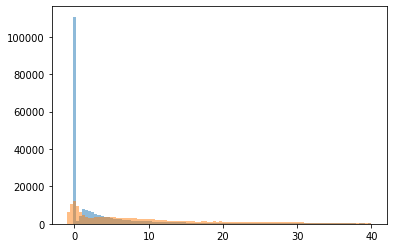

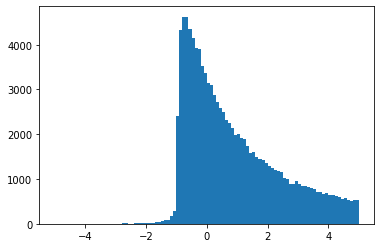

In [10]:
diff = []
output_px = []
input_px = []
for i in range(len(input_x)):
    diff.append(((output_x[i][:,3]-input_x[i][:,3])/input_x[i][:,3]).flatten())
    output_px.append(output_x[i][:,3].flatten())
    input_px.append(input_x[i][:,3].flatten())
    
all_diff = np.concatenate(diff)
all_input_px = np.concatenate(input_px)
all_output_px = np.concatenate(output_px)

print(all_input_px.shape)
print(all_output_px.shape)

plt.figure()
plt.hist(all_input_px, bins=np.linspace(-1, 40, 101),alpha=0.5)
plt.hist(all_output_px, bins=np.linspace(-1, 40, 101),alpha=0.5)

plt.figure()
plt.hist(all_diff, bins=np.linspace(-5, 5, 101))